2it [00:00,  5.97it/s]

err: 2.29e+04, lr: 0.0037999, last batch: None


307it [00:08, 46.14it/s]

err: 9.96e+03, lr: 0.0104293, last batch: 16


605it [00:15, 31.61it/s]

err: 6.26e+03, lr: 0.0057929, last batch: 8


902it [00:27, 16.21it/s]

err: 3.60e+03, lr: 0.0037066, last batch: 2


1203it [00:47, 18.35it/s]

err: 1.81e+03, lr: 0.0027603, last batch: 1


1501it [01:05, 11.13it/s]

err: 7.22e+02, lr: 0.0020452, last batch: 1


1520it [01:06, 22.92it/s]


best error: 7.22e+02


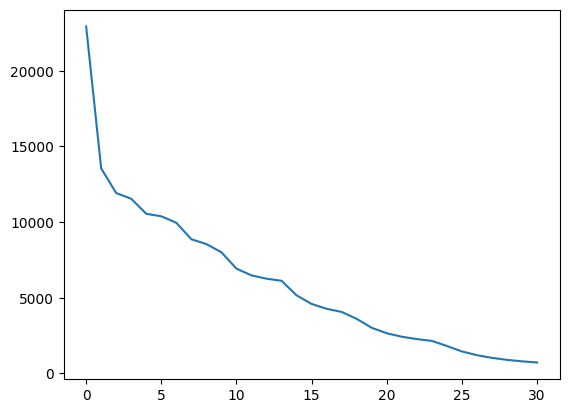

In [8]:
from data_reader import read_interaction_matrix
R = read_interaction_matrix()

from mf import matrix_factorization
from matplotlib import pyplot as plt

def get_errors(logs):
    errors = [log[0] for log in logs]
    return errors

q, p, err, logs = matrix_factorization(
    R, lr=(2e-2, 2e-3), n_epochs=1520, ff=0.05, reg=0.001, n_latent=64, log_step=50, print_step=300,
    sample_s=0.1, batch_sample_s=0.1
    )
errors = get_errors(logs)
 
print(f'best error: {err:.2e}')
plt.plot(errors)

In [9]:
import numpy as np

S = (q @ p.T)

def frmt(f):
    i = 5
    i += 1 if f < 0 else 0
    return str(f)[:i]

def describe(M, name=None):
    print((f'{name}\t' if name else '') + f'mean: {frmt(M.mean())}, min: {frmt(M.min())}, max: {frmt(M.max())}')

describe(R, 'R stat')
describe(S, 'S stat')
describe(S[R.nonzero()], 'Positives stat')
describe((S - S*R), 'Others stat')

frmt(S.sum()), frmt(R.sum()), S[R.nonzero()]

R stat	mean: 0.023, min: 0.0, max: 1.0
S stat	mean: 0.134, min: -0.935, max: 1.513
Positives stat	mean: 0.974, min: 0.518, max: 1.513
Others stat	mean: 0.111, min: -0.935, max: 1.377


('13240',
 '23038',
 array([1.13774073, 0.9311346 , 1.12704426, ..., 0.91729925, 0.92151917,
        0.92599542]))

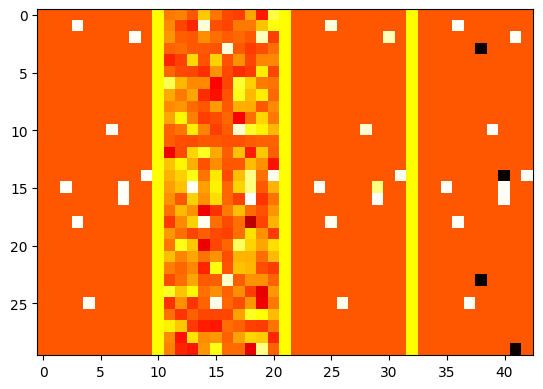

In [10]:
from mf import heatmap
import numpy as np

S = q @ p.T

FP = np.zeros_like(S)
FP[S > S.max() * 0.5] = -1
FP[R.nonzero()] = 1

P = S * R
Z = S - (S * R)

D = np.zeros((P.shape[0], 1))
D[:,0] = 0.5

t = tuple(M[60:90, 0:10] for M in (R, D, S, D, P, D, FP))
V = np.concatenate(t, axis=1)
heatmap(V)